# **Prepare**

## Import

In [11]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import statsmodels.formula.api as smf
from scipy.stats import norm 
from scipy import stats, integrate

from IPython.display import HTML
import folium
from folium.plugins import HeatMap
from math import sqrt


from sklearn import neighbors
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Preparation

In [12]:
def wrangle(path):
    # Read csv file into dataframe
    df = pd.read_csv(path)

    # Select the features
    # df = df[[ 'YEAR', 'DATE', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT',
    # 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 
    # 'PEDCOND',  'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK','TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT',
    # 'ALCOHOL', 'DISABILITY', 'POLICE_DIVISION','NEIGHBOURHOOD']]
    ## Dropping columns where missing values were greater than 80%
    df = df.drop(["PEDTYPE", "PEDACT", "PEDCOND"], axis=1)
    # Changing the property damage and non-fatal columns to Non-Fatal
    df['ACCLASS'] = np.where(df['ACCLASS'] == 'Property Damage Only', 'Non-Fatal', df['ACCLASS'])
    df['ACCLASS'] = np.where(df['ACCLASS'] == 'Non-Fatal Injury', 'Non-Fatal', df['ACCLASS'])
    
    df['MONTH'] = pd.to_datetime(df['DATE']).dt.month
    df['MONTH_NAME'] = pd.to_datetime(df['DATE']).dt.month_name()
    df['DAY'] = pd.to_datetime(df['DATE']).dt.day
    df['MINUTES'] = pd.to_datetime(df['DATE']).dt.minute
    df['WEEKDAY'] = pd.to_datetime(df['DATE']).dt.weekday


    return df    

path = 'data/KSI.csv'
df = wrangle(path)
print(df.shape)

(16860, 59)


In [13]:
df.head()

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,...,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,MONTH,MONTH_NAME,DAY,MINUTES,WEEKDAY
0,-8.844611e+06,5.412414e+06,3387730,892658,2006,2006/03/11 05:00:00+00,852,8,BLOOR ST W,DUNDAS ST W,...,No,D11,88,High Park North (88),1,3,March,11,0,5
1,-8.844611e+06,5.412414e+06,3387731,892658,2006,2006/03/11 05:00:00+00,852,8,BLOOR ST W,DUNDAS ST W,...,No,D11,88,High Park North (88),2,3,March,11,0,5
2,-8.816480e+06,5.434843e+06,3388101,892810,2006,2006/03/11 05:00:00+00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,...,No,D42,131,Rouge (131),3,3,March,11,0,5
3,-8.816480e+06,5.434843e+06,3388102,892810,2006,2006/03/11 05:00:00+00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,...,No,D42,131,Rouge (131),4,3,March,11,0,5
4,-8.822759e+06,5.424516e+06,3387793,892682,2006,2006/03/12 05:00:00+00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,...,No,D41,138,Eglinton East (138),5,3,March,12,0,6


In [14]:
df.describe()

,X,Y,INDEX_,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,HOOD_ID,ObjectId,MONTH,DAY,MINUTES,WEEKDAY
count,1.686000e+04,1.686000e+04,1.686000e+04,1.686000e+04,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.0,16860.000000
mean,-8.838272e+06,5.420819e+06,3.475220e+07,2.263460e+09,2012.256168,1352.106821,13.241103,43.710920,-79.395546,74.003618,8430.500000,6.802610,15.617023,0.0,3.003796
std,1.159490e+04,8.664361e+03,3.657126e+07,3.263836e+09,4.252797,629.726747,6.302679,0.056254,0.104159,41.411541,4867.207105,3.288337,8.847798,0.0,1.971048
min,-8.865305e+06,5.402256e+06,3.363207e+06,2.530100e+04,2006.000000,0.000000,0.000000,43.590289,-79.638390,1.000000,1.000000,1.000000,1.000000,0.0,0.000000
25%,-8.846402e+06,5.413345e+06,5.358714e+06,1.065135e+06,2009.000000,913.000000,9.000000,43.662398,-79.468578,39.000000,4215.750000,4.000000,8.000000,0.0,1.000000
50%,-8.838358e+06,5.419639e+06,7.474276e+06,1.293196e+06,2012.000000,1442.000000,14.000000,43.703284,-79.396323,77.000000,8430.500000,7.000000,16.000000,0.0,3.000000
75%,-8.829527e+06,5.427906e+06,8.063194e+07,5.001806e+09,2016.000000,1845.000000,18.000000,43.756945,-79.316990,112.000000,12645.250000,10.000000,23.000000,0.0,5.000000
max,-8.808254e+06,5.443099e+06,8.154201e+07,9.085345e+09,2020.000000,2359.000000,23.000000,43.855445,-79.125896,140.000000,16860.000000,12.000000,31.000000,0.0,6.000000


## Explore

### 1. Changing the property damage and non-fatal columns to Non-Fatal

In [15]:
df['ACCLASS'] = np.where(df['ACCLASS'] == 'Property Damage Only', 'Non-Fatal', df['ACCLASS'])
df['ACCLASS'] = np.where(df['ACCLASS'] == 'Non-Fatal Injury', 'Non-Fatal', df['ACCLASS'])
df.ACCLASS.value_counts()

Non-Fatal    14563
Fatal         2297
Name: ACCLASS, dtype: int64

### 2. Accident numbers against years and months

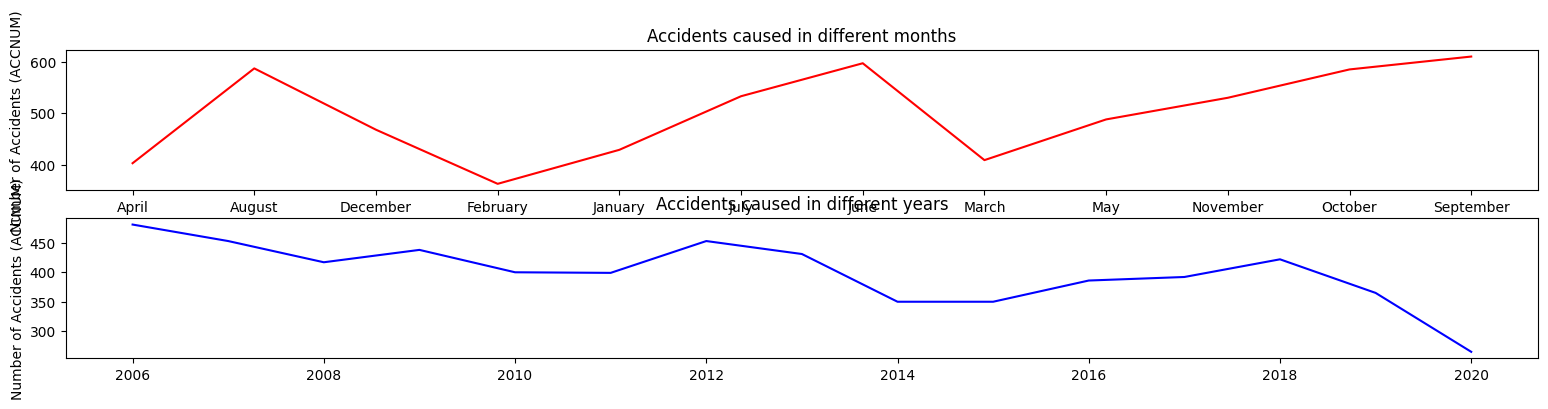

In [16]:
# #Number of Unique accidents by Year
Year_accident = df.groupby('YEAR')['ACCNUM'].nunique().sort_index(ascending=True)
Month_accident = df.groupby('MONTH_NAME')['ACCNUM'].nunique().sort_index(ascending=True)

fig, ax = plt.subplots(2,1,figsize=(19,4))


ax[1].set_title("Accidents caused in different years")
ax[1].set_ylabel('Number of Accidents (ACCNUM)')
ax[1].plot(Year_accident, color='blue')


ax[0].set_title("Accidents caused in different months")
ax[0].set_ylabel('Number of Accidents (ACCNUM)')
ax[0].plot(Month_accident, color='red')

plt.show()

### 3. Fatality Heatmap of those that where Fatally Injured

In [17]:
df_Fatal = df[df['INJURY'] == 'Fatal']
df_Fatal = df_Fatal[['LATITUDE', 'LONGITUDE']]
lat_Toronto_1 = df_Fatal.describe().at['mean','LATITUDE']
lng_Toronto_1 = df_Fatal.describe().at['mean','LONGITUDE']
Toronto_location_F = [lat_Toronto_1, lng_Toronto_1]
Fatal_map_F = folium.Map(Toronto_location_F, zoom_start=10.255)
HeatMap(df_Fatal.values, min_opacity =0.3).add_to(Fatal_map_F)
Fatal_map_F



### 4. Fatality Heatmap of those that where not Fatally Injured

In [18]:
df_Non_Fatal = df[df['INJURY'] != 'Fatal']
df_Non_Fatal = df_Non_Fatal[['LATITUDE', 'LONGITUDE']]
lat_Toronto_2 = df_Non_Fatal.describe().at['mean','LATITUDE']
lng_Toronto_2 = df_Non_Fatal.describe().at['mean','LONGITUDE']
Toronto_location_N = [lat_Toronto_2, lng_Toronto_2]
Fatal_map_N = folium.Map(Toronto_location_F, zoom_start=10.255)
HeatMap(df_Fatal.values, min_opacity =0.3).add_to(Fatal_map_N)
Fatal_map_N

### 5. Fatality over years (# of people died)

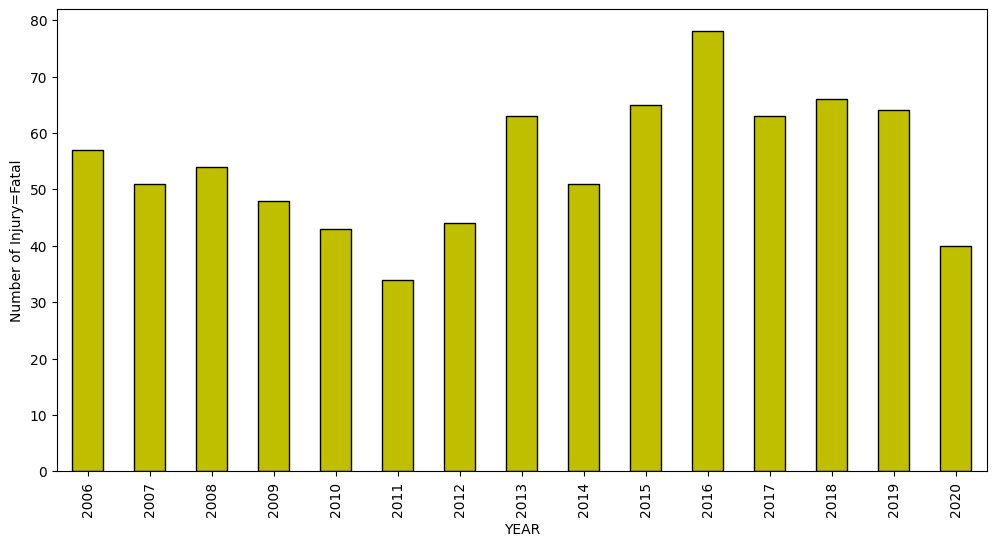

In [19]:
#Lets look at Fatality over years (# of people died)
Fatality = df[df['INJURY'] =='Fatal']
Fatality = Fatality.groupby(df['YEAR']).count()
plt.figure(figsize=(12,6))


plt.ylabel('Number of Injury=Fatal')
Fatality['INJURY'].plot(kind='bar',color="y" , edgecolor='black')

plt.show()

### 6. Looking at area where accident happens



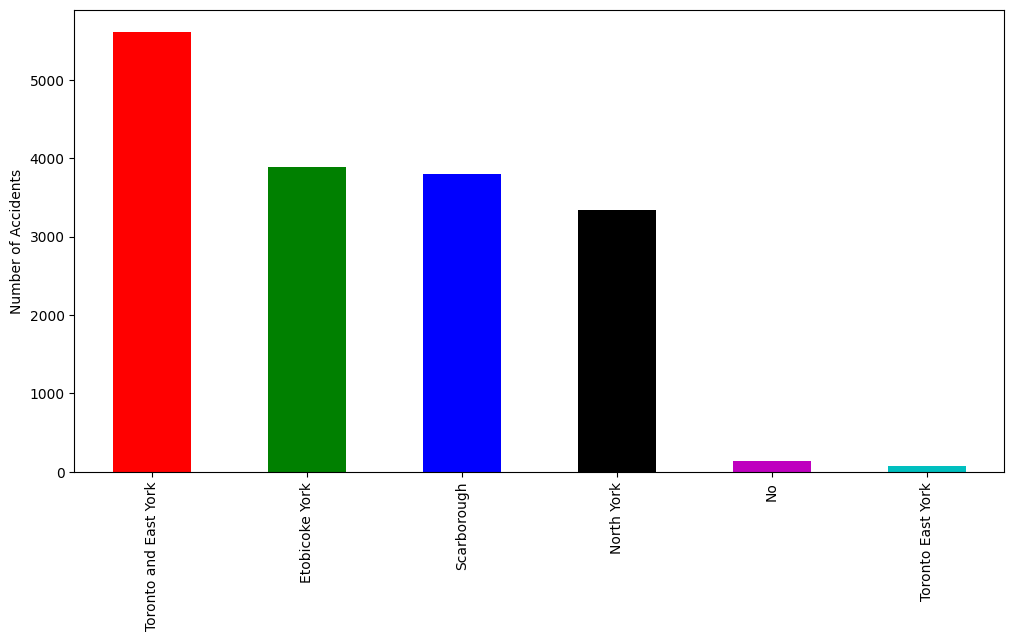

In [20]:
Region_df = df['DISTRICT'].value_counts()
plt.figure(figsize=(12,6))
plt.ylabel('Number of Accidents')
Region_df.plot(kind='bar',color=list('rgbkmc') )
plt.show()

### 7. Top 10 Neighbourhood with Most collisions

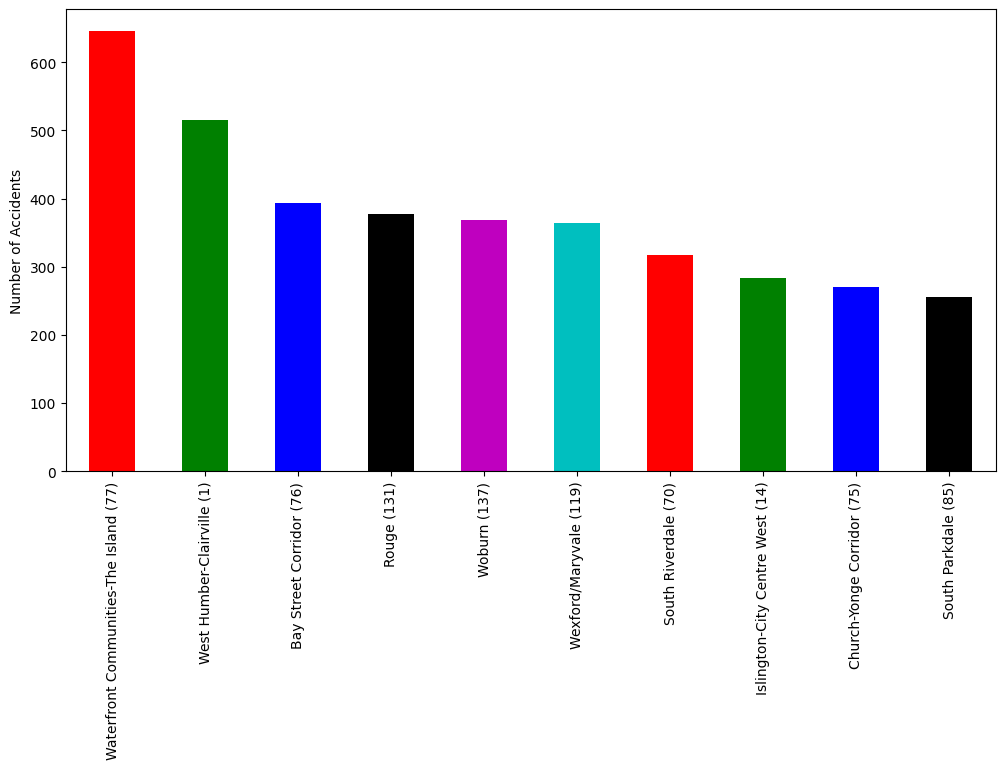

In [21]:
Hood_df = df['NEIGHBOURHOOD'].value_counts()
plt.figure(figsize=(12,6))
plt.ylabel('Number of Accidents')
Hood_df.nlargest(10).plot(kind='bar',color=list('rgbkmc') )
plt.show()

In [22]:
def conut_feature(df, xlabel, title):
    ax = sns.countplot(x=df)

    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14)
    plt.yticks(size=12)
    plt.ylabel('Number of Traffic Collisions', size=12)
    plt.title(title, size=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.tight_layout()
    plt.show()

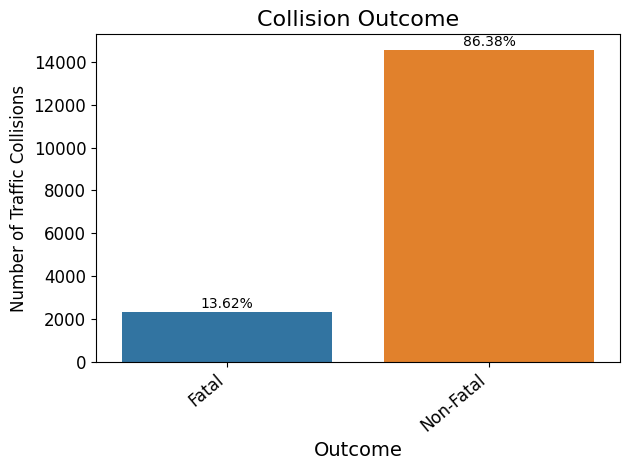

In [23]:
# What is the percentage of OUTCOME?
conut_feature(df['ACCLASS'], 'Outcome', 'Collision Outcome')

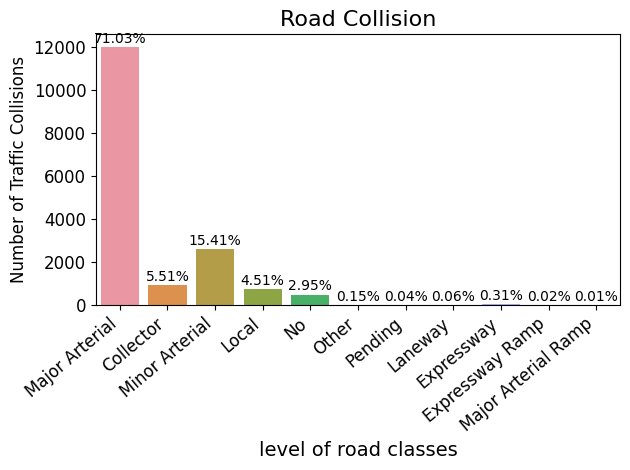

In [24]:

conut_feature(df['ROAD_CLASS'], 'level of road classes',"Road Collision")


### Data cleaning

In [25]:
df_clean_data = df[['ACCNUM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTES', 'WEEKDAY', 'LATITUDE', 'LONGITUDE', 
'DISTRICT', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 
    'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'ACCLASS']]

# Transforming the coordinates
df_clean_data['LATITUDE'] = df_clean_data['LATITUDE'].astype('int')
df_clean_data['LONGITUDE'] = df_clean_data['LATITUDE'].astype('int')

C:\Users\HP\AppData\Local\Temp\ipykernel_14100\2944973631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_data['LATITUDE'] = df_clean_data['LATITUDE'].astype('int')
C:\Users\HP\AppData\Local\Temp\ipykernel_14100\2944973631.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_data['LONGITUDE'] = df_clean_data['LATITUDE'].astype('int')


In [26]:
print("Percentage of missing values in the KSI_CLEAN_data dataset")
df_clean_data.isna().sum()/len(df_clean_data)*100

Percentage of missing values in the KSI_CLEAN_data dataset


ACCNUM           0.0
YEAR             0.0
MONTH            0.0
DAY              0.0
HOUR             0.0
MINUTES          0.0
WEEKDAY          0.0
LATITUDE         0.0
LONGITUDE        0.0
DISTRICT         0.0
VISIBILITY       0.0
LIGHT            0.0
RDSFCOND         0.0
PEDESTRIAN       0.0
CYCLIST          0.0
AUTOMOBILE       0.0
MOTORCYCLE       0.0
TRUCK            0.0
TRSN_CITY_VEH    0.0
EMERG_VEH        0.0
PASSENGER        0.0
SPEEDING         0.0
AG_DRIV          0.0
REDLIGHT         0.0
ALCOHOL          0.0
DISABILITY       0.0
ACCLASS          0.0
dtype: float64

#### Encoding

In [27]:
df_clean_data = pd.get_dummies(df_clean_data, columns=['VISIBILITY','RDSFCOND','LIGHT','DISTRICT','PEDESTRIAN','CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 
    'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY'])

df_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 70 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ACCNUM                             16860 non-null  int64 
 1   YEAR                               16860 non-null  int64 
 2   MONTH                              16860 non-null  int64 
 3   DAY                                16860 non-null  int64 
 4   HOUR                               16860 non-null  int64 
 5   MINUTES                            16860 non-null  int64 
 6   WEEKDAY                            16860 non-null  int64 
 7   LATITUDE                           16860 non-null  int32 
 8   LONGITUDE                          16860 non-null  int32 
 9   ACCLASS                            16860 non-null  object
 10  VISIBILITY_Clear                   16860 non-null  uint8 
 11  VISIBILITY_Drifting Snow           16860 non-null  uint8 
 12  VISI

### Finding Important features

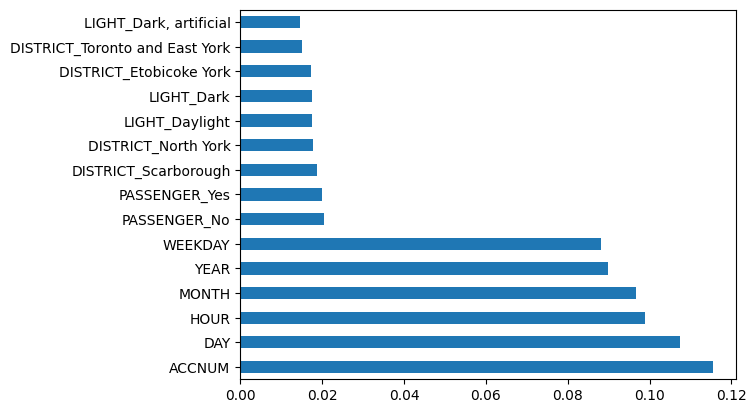

In [28]:
X = df_clean_data.drop('ACCLASS', axis=1)
y = df_clean_data['ACCLASS']    #target column i.e price range

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
 #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [29]:
feat_importances.sort_values(ascending=False)[:10]

ACCNUM                  0.115386
DAY                     0.107495
HOUR                    0.098760
MONTH                   0.096569
YEAR                    0.089782
WEEKDAY                 0.088214
PASSENGER_No            0.020422
PASSENGER_Yes           0.019873
DISTRICT_Scarborough    0.018647
DISTRICT_North York     0.017766
dtype: float64

In [30]:
df_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 70 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ACCNUM                             16860 non-null  int64 
 1   YEAR                               16860 non-null  int64 
 2   MONTH                              16860 non-null  int64 
 3   DAY                                16860 non-null  int64 
 4   HOUR                               16860 non-null  int64 
 5   MINUTES                            16860 non-null  int64 
 6   WEEKDAY                            16860 non-null  int64 
 7   LATITUDE                           16860 non-null  int32 
 8   LONGITUDE                          16860 non-null  int32 
 9   ACCLASS                            16860 non-null  object
 10  VISIBILITY_Clear                   16860 non-null  uint8 
 11  VISIBILITY_Drifting Snow           16860 non-null  uint8 
 12  VISI

## Split

In [31]:
target = 'ACCLASS'
X = df_clean_data.drop(target, axis=1)
y = df_clean_data[target].map({'Fatal':1,'Non-Fatal':0})

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **Build Model**

## Model 1 - XGBoost Classifier

In [33]:
model_1 = make_pipeline(
    StandardScaler(),
    SimpleImputer(),
    XGBClassifier(),
)
model_1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [40]:
model_1_pred = model_1.predict(X_test)
model_1_acc = accuracy_score(y_test, model_1_pred)
model_1_pre = precision_score(y_test, model_1_pred)
model_1_rec = recall_score(y_test, model_1_pred)
print(f'Model Accuracy: {model_1_acc}')
print(classification_report(y_test, model_1_pred))

Model Accuracy: 0.9396994859628311
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4345
           1       0.94      0.61      0.74       713

    accuracy                           0.94      5058
   macro avg       0.94      0.80      0.85      5058
weighted avg       0.94      0.94      0.93      5058



## Model 2 - Suppor Vector Classifier

In [41]:
from sklearn.svm import SVC
model_2 = make_pipeline(
    StandardScaler(),
    SimpleImputer(),
    SVC()
)
model_2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()), ('svc', SVC())])

In [42]:
model_2_pred = model_2.predict(X_test)
model_2_acc = accuracy_score(y_test, model_2_pred)
model_2_pre = precision_score(y_test, model_2_pred)
model_2_rec = recall_score(y_test, model_2_pred)
print(f'Model Accuracy: {model_2_acc}')
print(classification_report(y_test, model_2_pred))

Model Accuracy: 0.8669434559114274
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4345
           1       0.88      0.06      0.12       713

    accuracy                           0.87      5058
   macro avg       0.88      0.53      0.52      5058
weighted avg       0.87      0.87      0.81      5058



## Evaluate

In [43]:
names = ['XGBClassifier', 'Support Vector Classifier']
acc_score = [model_1_acc, model_2_acc]
pre_score = [model_1_pre, model_2_pre]
rec_score = [model_1_rec, model_2_rec]

models = pd.DataFrame()
models['Models'] = names
models['Accuracy'] = acc_score
models['Precision'] = pre_score
models['Recall'] = rec_score

In [44]:
models.head()

,Models,Accuracy,Precision,Recall
0,XGBClassifier,0.939699,0.941558,0.610098
1,Support Vector Classifier,0.866943,0.884615,0.064516


<AxesSubplot:xlabel='Models', ylabel='Accuracy'>

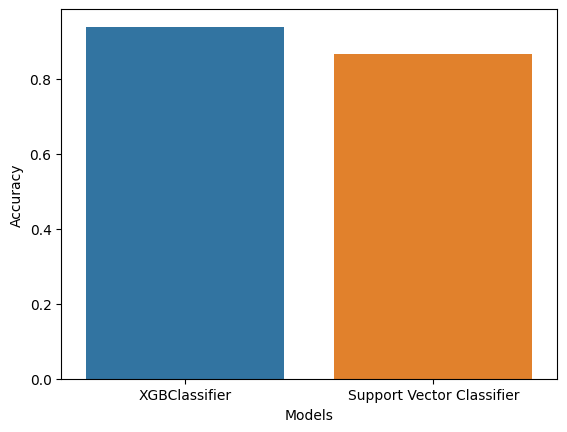

In [45]:
sns.barplot(x='Models', y='Accuracy', data=models)

- The XGBClassifier outperformed the Support Vector Classifier with respect to the following accuracy [0.939699, 0.866943]

<AxesSubplot:xlabel='Models', ylabel='Precision'>

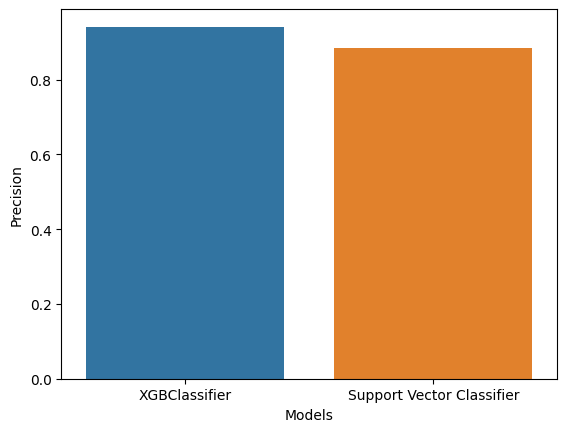

In [46]:
sns.barplot(x='Models', y='Precision', data=models)

<AxesSubplot:xlabel='Models', ylabel='Recall'>

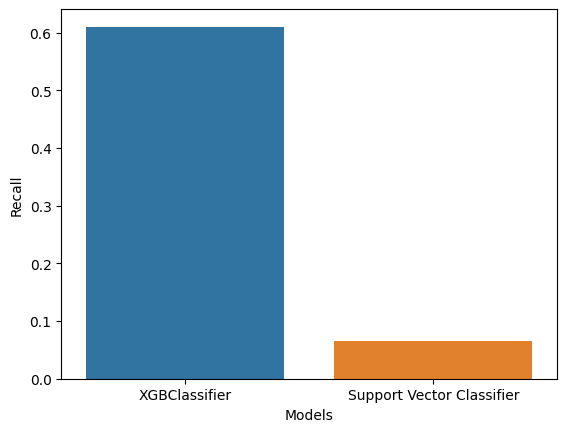

In [47]:
sns.barplot(x='Models', y='Recall', data=models)